In [58]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from typing import Literal, Callable, Optional
from functools import partial
from sklearn.datasets import load_iris, make_blobs

# 支持向量机
支持向量机(Support Vector Machines)是一种用于二分类的学习算法，和[感知机](./perceptron.ipynb)、[逻辑回归](./logistic_regression.ipynb)一样，我们先回顾下感知机和逻辑回归在寻求超平面时是如何做的

感知机希望犯错的点尽可能少，超平面能够将两类点分开。逻辑回归是不仅希望超平面能够将两类点分开，并且考虑到数据中存在噪音，希望分错的点尽量在决策边界附近。

![感知机](../resources/support_vector_machines1.png) ![逻辑回归](../resources/support_vector_machines2.png)

支持向量机也是寻找一个超平面将两类点分开，但是支持向量和逻辑回归一样，也考虑到数据中存在噪音，希望分对的点尽量原理决策边界。

> 逻辑回归的经验误差为
> $$\hat{R}_D(h)=\sum_{i}(y_i-\boldsymbol{w}^\mathrm{T})^2$$
> 对于分错的点，其带来的值会比较大，而对于分对的点，值是小于1的，因此分对的点对于决策边界影响较小，这也是和感知机在寻找超平面的方案的区别。

远离决策边界意味着能够处理噪音，数据集$D$中的某一个元素可能代表总体的某一个类别，比如在信用卡发放中，对于存款2万，年薪1万的用户不发放信用卡，那么对于$(2.1, 1.1)$可能属于同类用户，也不允发放。那么只要分对的点离决策边界比较远，同类型的用户就能够正确分类。

## 决策边界的宽度和支持向量
如下图，决策边界的宽度(margin of decsion boundary)是阴影的宽度，是决策边界上下平移后，第一次触碰到数据集$D$中的点后停止平移，两条平行线的距离就是决策边界的宽度。这些点被称为支持向量(support vector)。

![](../resources/support_vector_machines3.svg)

对于线性可分的数据集，支持向量机找到的决策边界满足以下两个要求：
- 将数据集$D$中的点正确分类
- 决策边界的宽度最大

## 硬间隔支持向量机
对于线性可分的数据集，支持向量机要求决策边界宽度内不能包含点，这种应用于线性可分的数据集的支持向量机称为硬间隔支持向量机(Hard Margin Support Vector Machine)。

对于决策边界$\boldsymbol{w}\boldsymbol{x}+b=0$，其决策边界的宽度为

$$\begin{aligned}
    \boldsymbol{w}\boldsymbol{x}+b\ &= \ +1 \\
    \boldsymbol{w}\boldsymbol{x}+b\ &= \ -1 
\end{aligned}$$

那么硬间隔支持向量机寻找的决策边界需要满足
- 能够将数据集$D$正确分类

$$y_i(\boldsymbol{w}\cdot\boldsymbol{x_i}+b)\ge 1$$
- 决策边界的宽度最大

$$\max\frac{2}{||\boldsymbol{w}||}$$

将上述两个要求转化为条件极值

$$\begin{aligned}
    \min_{\boldsymbol{w},b}\quad
        &\frac{1}{2}||\boldsymbol{w}||^2\\
    s.t.\quad
        &y_i(\boldsymbol{w}\cdot\boldsymbol{x_i}+b)\ge 1
\end{aligned}$$

可以通过拉格朗日乘数法和KKT条件，对应的拉格朗日函数为

$$L=\frac{1}{2}||\boldsymbol{w}||^2+\sum_{i=1}\lambda_i[1-y_i(\boldsymbol{w}\cdot \boldsymbol{x}_i+b)]$$

对应的方程组为

$$\begin{cases}
    \displaystyle\frac{\partial L}{\partial \boldsymbol{w}}=0,\displaystyle\frac{\partial L}{\partial b}=0\\
    \\
    \lambda_i(1-y_i(\boldsymbol{w}\cdot \boldsymbol{x}_i+b))=0\\
    \\
    \lambda_i\ge 0,1-y_i(\boldsymbol{w}\cdot \boldsymbol{x}_i+b)\le 0
\end{cases}$$

该方程组可以使用python中的凸优化库cvxpy来解答

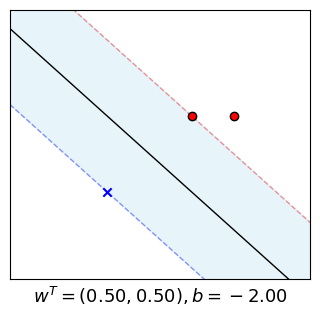

In [33]:
X = np.array([[3, 3],[4, 3],[1, 1],])
y = np.array([1,1,-1,])

n = X.shape[1]	
w = cp.Variable((n,1))
b = cp.Variable()
objective = cp.Minimize(0.5*cp.norm(w)**2)
constraints = [cp.multiply(y.reshape(-1,1), X@w + b) >= 1 ] 
prob = cp.Problem(objective, constraints) 
prob.solve(solver=cp.ECOS)

def h(xx):
	return - w.value[0]/w.value[1] * xx  - b.value / w.value[1]

plt.rcParams.update({'font.size': 13})
x1_min, x1_max = -1, 5.5
x2_min, x2_max = -1, 5.5
fig, ax = plt.subplots(figsize = (6, 3), nrows=1, ncols=1)
fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1)
ax.set_xticks(()),ax.set_yticks(())
ax.set_xlim(x1_min-0.3, x1_max+0.3),ax.set_ylim(x2_min-0.3, x2_max+0.3)
ax.set_xlabel(r'$w^T=({:.2f},{:.2f}), b={:.2f}$'.format(w.value[0][0], w.value[1][0], b.value))
markers = ('x', 'o')
colors = ('blue', 'red')
for cl, m, color in zip(np.unique(y), markers, colors):
	edgecolors = 'k'
	if m == 'x':
		edgecolors = None
	ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, c=color, 
			edgecolors=edgecolors, marker = m, zorder=9)

# 绘制决策边界的宽度
xx1 = np.arange(x1_min-1, x1_max+1, 0.1)
ax.plot(xx1, h(xx1)+1/w.value[1], 'r--', lw=1, alpha=0.4)	# 宽度上界
ax.plot(xx1, h(xx1), 'k', lw=1)								# 决策边界
ax.plot(xx1, h(xx1)-1/w.value[1], 'b--', lw=1, alpha=0.4)	# 宽度下界
ax.fill_between(xx1, h(xx1)-1/w.value[1], h(xx1)+1/w.value[1], color='skyblue', alpha=0.2)

plt.show()

### 硬间隔支持向量机的对偶算法

前面使用拉格朗日乘数法和KKT条件来求解支持向量机，计算过程非常复杂，现在从另一个思路考虑，如果能够在数据集中找到支持向量，那不就能够确定决策边界。于是引入下列算法

通过求解下列有条件极值，可以得到数据集$D$中某个点$(\boldsymbol{x_i}, y_i)$所对应的$\lambda_i$:

$$\begin{aligned}
    \min_{\boldsymbol{\lambda}}\quad
        &\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^{\text{T}}\boldsymbol{x}_j-\sum_{i=1}^{n}\lambda_i\\
    s.t.\quad
        &\lambda_i \geq 0,\quad\sum_{i=1}^{n}\lambda_i y_i=0\\
\end{aligned}$$

如果$\lambda_i \ne 0$，那么该点就是支持向量，所有支持向量的集合为$K=\{(\boldsymbol{x_k},y_k)\}$，那么

$$\hat{\boldsymbol{w}}=\sum_{k}\lambda_ky_k\boldsymbol{x}_k$$

再从支持向量随机挑选一个点$(\boldsymbol{x_j},y_j)\in K$，则

$$\hat{b}=y_j-\sum_{k}\lambda_ky_k\boldsymbol{x}_k^{\mathrm{T}}\boldsymbol{x}_j$$

上述算法称为对偶算法，是从原算法中推导出来的。

In [34]:
def SVM_dual_problem(X: np.ndarray, y: np.ndarray) -> (np.ndarray, np.ndarray, float):
    """
    SVM对偶算法
    X: shape[m, n]
    Y: shape[m,]

    returns: lambda, w, b
    """
    m = X.shape[0]
    # 构造约束条件
    lambdas = cp.Variable(m)
    constraint_1 = [lambdas[i] >=0 for i in range(m)]
    constraint_2 = [lambdas@y.T == 0]
    # 构造优化的目标
    yX = y.reshape(-1,1)*X
    K = yX@yX.T
    objective_dual = cp.Minimize(1/2*cp.quad_form(lambdas,K)-cp.sum(lambdas))
    # 构造凸优化问题并求解
    prob_dual = cp.Problem(objective_dual,constraint_1+constraint_2)
    prob_dual.solve()

    # 得到支持向量
    lambdas = lambdas.value
    support_y = y[lambdas > 0.00001]
    support_X = X[lambdas > 0.00001]
    support_lambdas = lambdas[lambdas > 0.00001]

    # 根据支持向量算出 w 和 b
    w = np.sum((support_lambdas*support_y).reshape(-1, 1)*support_X, axis=0)
    b = support_y[0] - np.sum((support_lambdas*support_y).reshape(-1, 1)*support_X@support_X[0].reshape(-1,1))
    return lambdas, w, b

lambdas, w, b = SVM_dual_problem(X, y)
# print(lambdas, w, b)
print('λ1 ≈ {:.6f}, λ2 ≈ {:.6f}, λ3 ≈ {:.6f}'.format(lambdas[0], lambdas[1], lambdas[2]))
print('w1 ≈ {:.6f}, w2 ≈ {:.6f}, b ≈ {:.6f}'.format(w[0], w[1], b))

λ1 ≈ 0.250000, λ2 ≈ 0.000000, λ3 ≈ 0.250000
w1 ≈ 0.500000, w2 ≈ 0.500000, b ≈ -2.000000


也可以使用sklearn封装好的svm

In [35]:
def SVM_in_sklearn(X: np.ndarray, y: np.ndarray, **kwargs) -> (np.ndarray, float):
    return_svm = kwargs.pop("return_svm") if "return_svm" in kwargs else False
    clf = svm.SVC(kernel="linear")
    if len(kwargs) > 0:
        clf = svm.SVC(**kwargs)
    clf.fit(X, y)
    if return_svm:
        return clf
    else:
        return clf.coef_[0], clf.intercept_[0]

w, b = SVM_in_sklearn(X, y)
print('w1 ≈ {:.6f}, w2 ≈ {:.6f}, b ≈ {:.6f}'.format(w[0], w[1], b))

w1 ≈ 0.500000, w2 ≈ 0.500000, b ≈ -2.000000


#### 非线性分类
对于非线性可分的数据集，可以使用多项式的假设空间来将数据集划分，和[感知机](./perceptron.ipynb)思路一样，首先进行特征转换，然后将问题转化为线性的，就可以继续使用感知机来寻找决策边界了。

如下，使用假设空间

$$\mathcal{H}=\{\ h(\boldsymbol{x})=\boldsymbol{w}^\mathrm{T}\boldsymbol{x}^2+b\ \}$$

经过特征转换后，数据集变得线性可分了。

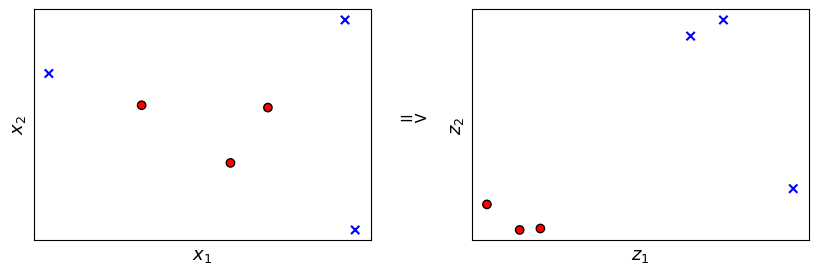

In [36]:
X = np.array([[-1.8, 0.6], [0.48, -1.36], [3.68, -3.64], [1.44, 0.52], [3.42, 3.5], [-4.18, 1.68], ])
Z = X**2
y = np.array([1, 1, -1, 1, -1, -1, ])

fig, axes = plt.subplots(figsize=(10, 3), ncols=2, nrows=1)
fig.subplots_adjust(wspace=0.3)
fig.text(0.49, 0.5, "=>")
labels=(("$x_1$", "$x_2$"), ("$z_1$", "$z_2$"))
cm = ListedColormap(("blue", "red"))
for xx, label, ax in zip((X, Z), labels, axes):
    ax.set(xticks=[], yticks=[])
    x0, x1 = xx[:, 0], xx[:, 1]
    ax.set_xlabel(label[0]), ax.set_ylabel(label[1])
    for cl, m in zip(np.unique(y), markers):
        edgecolors = 'k'
        if m == 'x':
            edgecolors = None
        ax.scatter(x=x0[y==cl], y=x1[y==cl], c=y[y==cl], vmin=-1, 
                   vmax=1, cmap=cm, edgecolors=edgecolors, marker=m)

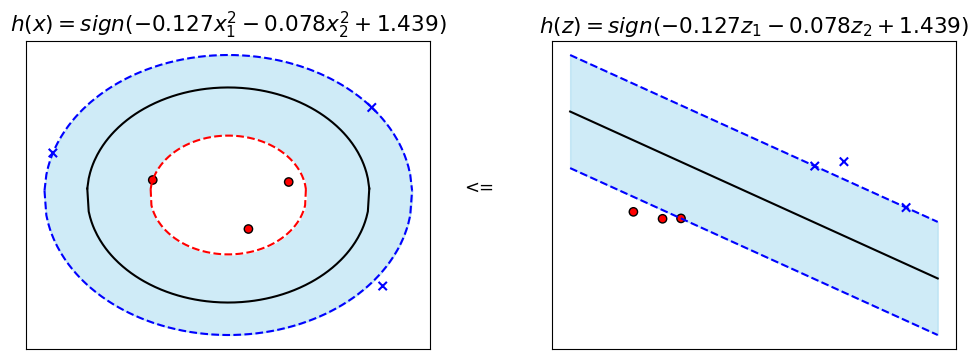

In [37]:
w, b = SVM_in_sklearn(Z, y)
fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
fig.subplots_adjust(wspace=0.3)
fig.text(0.49, 0.5, "<=")
titles = (r"$h(x)=sign({0:#.3f}x_1^2{1:+#.3f}x_2^2{2:+#.3f})$".format(w[0], w[1], b),
          r"$h(z)=sign({0:#.3f}z_1{1:+#.3f}z_2{2:+#.3f})$".format(w[0], w[1], b))

def h(x, w, b):
    return (x, -w[0]/w[1]*x-b/w[1])
    
xx = np.linspace(Z.min()-4, Z.max()+2)
x_, y_ = h(xx, w, b)
axes[1].plot(x_, y_-1/w[1], color='blue', linestyle='--')
axes[1].plot(x_, y_, color='black')
axes[1].plot(x_, y_+1/w[1], color='blue', linestyle='--')
axes[1].fill_between(x_, y_-1/w[1], y_+1/w[1], color="skyblue", alpha=0.4)

def plot_circle(x, y, ax, **kwargs):
    y_ = -y
    y_[0], y_[-1] = -y_[0], -y_[-1]
    ax.plot(x, y, x, y_, **kwargs)

x1_ = np.linspace(-3.36, 3.36, 200)
y1_ = np.sqrt(h(x1_**2, w, b)[1])
plot_circle(x1_, y1_, axes[0], color="black")

x2_ = np.linspace(-4.38, 4.38, 200)
y2_ = np.sqrt(h(x2_**2, w, b)[1]-1/w[1])
plot_circle(x2_, y2_, axes[0], color='blue', linestyle='--')

x3_ = np.linspace(-1.85, 1.85, 200)
y3_ = np.sqrt(h(x3_**2, w, b)[1] + 1/w[1])
plot_circle(x3_, y3_, axes[0], color='red', linestyle='--')
axes[0].fill_between(x2_, -y2_, y2_, color="skyblue", alpha=0.4)
axes[0].fill_between(x3_, -y3_, y3_, color="white", alpha=1)

for ax, title, xx in zip(axes, titles, (X, Z)):
    ax: plt.Axes = ax
    ax.set(xticks=[], yticks=[])
    ax.set_title(title)
    x0, x1 = xx[:, 0], xx[:, 1]
    for cl, m in zip(np.unique(y), markers):
        edgecolors = 'k'
        if m == 'x':
            edgecolors = None
        ax.scatter(x=x0[y==cl], y=x1[y==cl], c=y[y==cl], vmin=-1, 
                   vmax=1, cmap=cm, edgecolors=edgecolors, marker=m)

plt.show()

可以把特征转换函数记作$\phi$，那么有

$$\boldsymbol{z}=\phi(\boldsymbol{x})$$

那么可以把对偶算法改写为

$$\begin{aligned}
    \min_{\boldsymbol{\lambda}}\quad
        &\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_i\lambda_jy_iy_j{\phi(\boldsymbol{x_i})^{\mathrm{T}}}{\phi(\boldsymbol{x_j})}-\sum_{i=1}^{n}\lambda_i\\
    s.t.\quad
        &\lambda_i \geq 0,\quad\sum_{i=1}^{n}\lambda_i y_i=0\\
\end{aligned}$$

如果$\lambda_i$不为0，表示$(\boldsymbol{x}_i, y_i)$是支持向量，因此$\hat{\boldsymbol{w}}$和$\hat{b}$可以改写为

$$\hat{\boldsymbol{w}}=\sum_{k}\lambda_ky_k{\phi(\boldsymbol{x}_k)},\quad\hat{b}=y_j-\sum_{k}\lambda_ky_k{\phi(\boldsymbol{x}_k)^{\mathrm{T}}\phi(\boldsymbol{x}_j)}$$

因此决策边界为

$$h(\boldsymbol{x})=\operatorname{sign}(\hat{\boldsymbol{w}}^\mathrm{T}{\phi(\boldsymbol{x})}+\hat{b})$$

举个更高维度的例子，现在将包含两个特征的数据经过特征转换后，特征向量的维度变成三维的了

$$\begin{pmatrix}x_1\\x_2\end{pmatrix}\xrightarrow{\quad\phi\quad}\begin{pmatrix}x_1^2\\x_2^2\\x_1x_2\end{pmatrix}$$

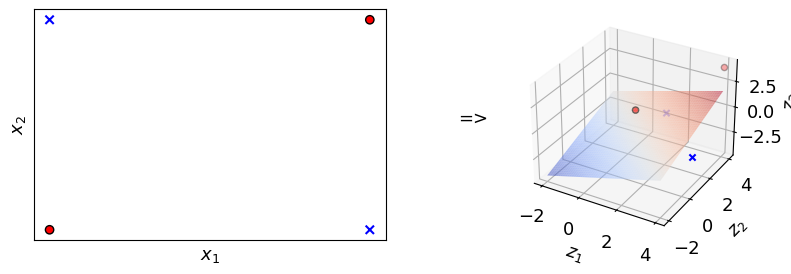

In [38]:
X = np.array([[-1,-1], [-1,2], [2,2], [2,-1]])
Z = np.hstack((X**2, (X[:,0]*X[:,1]).reshape(-1, 1), ))
y = np.array([1, -1, 1, -1, ])

fig = plt.figure(figsize=(10, 3))
fig.text(0.55, 0.5, "=>")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.set(xticks=[], yticks=[])
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
for cl, marker in zip(np.unique(y), markers):
    edgecolors = 'k'
    if marker == 'x':
        edgecolors = None
    ax1.scatter((X[:, 0])[y==cl], (X[:, 1])[y==cl], c=y[y==cl], vmin=-1, 
                vmax=1, cmap=cm, edgecolors=edgecolors, marker=marker)

ax2.set_xlabel("$z_1$")
ax2.set_ylabel("$z_2$")
ax2.set_zlabel("$z_3$")
# ax2.set(xticks=[], yticks=[], zticks=[])
for cl, marker in zip(np.unique(y), markers):
    edgecolors = 'k'
    if marker == 'x':
        edgecolors = None
    ax2.scatter((Z[:, 0])[y==cl], (Z[:, 1])[y==cl], (Z[:, 2])[y==cl], c=y[y==cl], vmin=-1, 
               vmax=1, cmap=cm, edgecolors=edgecolors, marker=marker)
    
w, b = SVM_in_sklearn(Z, y)
z1 = np.arange(-2, 4, 0.01)
z2 = np.arange(-2, 4, 0.01)
z1, z2 = np.meshgrid(z1, z2)
z3 = (-w[0]*z1-w[1]*z2-1)/w[2]
ax2.plot_surface(z1, z2, z3, cmap="coolwarm", alpha=0.5)

plt.show()

#### 核函数
特征转换函数$\phi(\boldsymbol{x})$可能计算量非常大，举个例子

$$\begin{pmatrix}x_1\\x_2\end{pmatrix}\xrightarrow{\quad\phi\quad}
\begin{pmatrix}x_1x_1\\x_1x_2\\x_2x_1\\x_2x_2\end{pmatrix}$$

对于每个特征需要4次乘法才能完成转换，接下来还需要执行一次点积运算，需要4次乘法和3次加法。

在机器学习中可以通过核技巧(kernel trick)来减少计算量，还是以上面的特征转换为例子，将计算降低到3次乘法和一次加法，通常使用函数$K$表示化简后的结果，该函数也称为核函数(kernel function)。

$$\begin{aligned}
    \phi(\boldsymbol{x_1})^\mathrm{T}\phi(\boldsymbol{x_2})
        &=x_{11}x_{11}\cdot x_{21}x_{21}+x_{11}x_{12}\cdot x_{21}x_{22}\\
        &\quad +x_{12}x_{11}\cdot x_{22}x_{21}+x_{12}x_{12}\cdot x_{22}x_{22}\\
        &=(x_{11}x_{21})^2+2x_{11}x_{21}\cdot x_{12}x_{22}+(x_{12}x_{22})^2\\
        &=(x_{11}x_{21}+x_{12}x_{22})^2=(\boldsymbol{x_1}^\mathrm{T}\boldsymbol{x_2})^2
\end{aligned}$$

使用核函数$K$，那么前面介绍的对偶算法改写为

$$\begin{aligned}
    \min_{\boldsymbol{\lambda}}\quad
        &\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_i\lambda_jy_iy_j{K(\boldsymbol{x}_i,\boldsymbol{x}_j)}-\sum_{i=1}^{n}\lambda_i\\
    s.t.\quad
        &\lambda_i \geq 0,\quad\sum_{i=1}^{n}\lambda_i y_i=0\\
\end{aligned}$$

由于

$$\hat{\boldsymbol{w}}=\sum_{k}\lambda_ky_k\phi(\boldsymbol{x}_k),\quad\hat{b}=y_j-\sum_{k}\lambda_ky_k\phi(\boldsymbol{x}_k)^{\mathrm{T}}\phi(\boldsymbol{x}_j)$$

因此决策边界为

$$\begin{aligned}
    h(\boldsymbol{x})
        &=\operatorname{sign}(\hat{\boldsymbol{w}}^\mathrm{T}\phi(\boldsymbol{x})+\hat{b})\\
        &=\operatorname{sign}\left(\sum_{k}\lambda_ky_k\phi(\boldsymbol{x}_k)^\mathrm{T}\phi(\boldsymbol{x})+y_j-\sum_{k}\lambda_ky_k\phi(\boldsymbol{x}_k)^{\mathrm{T}}\phi(\boldsymbol{x}_j)\right)\\
        &=\operatorname{sign}\left(\sum_{k}\lambda_ky_k{K(\boldsymbol{x}_k,\boldsymbol{x})}+y_j-\sum_{k}\lambda_ky_k{K(\boldsymbol{x}_k,\boldsymbol{x}_j)}\right)
\end{aligned}$$

下面介绍下常用的核函数

1. 线性核(Linear kernel)，其效果和没有核函数一样，需要注意的是，使用线性核后计算量反而增加了，这是因为在做预测的时候支持向量需要和$\boldsymbol{X}$做矩阵乘法。
    $$K(\boldsymbol{x_1},\boldsymbol{x_2})=\boldsymbol{x_1}^\mathrm{T}\boldsymbol{x_2}$$
    
2. 多项式核(Polynomial Kernel)

    $$K(\boldsymbol{x_1},\boldsymbol{x_2})=(\zeta+\gamma\boldsymbol{x_1}^\mathrm{T}\boldsymbol{x_2})^d,\quad \gamma \geq 0$$

    其中$\zeta$和$\gamma$是多项式的系数，$d$是多项式的最高次数，这三个都是超参数用于调节模型的复杂度。

3. 高斯核(Guassian Kernel)

    $$K(\boldsymbol{x_1}, \boldsymbol{x_2})=\exp \left[-\gamma\left\|\boldsymbol{x_1}-\boldsymbol{x_2}\right\|^{2}\right]=\phi(\boldsymbol{x_1})\cdot\phi(\boldsymbol{x_2})$$

    高斯核是无限维空间内的点积，下面举个例子说明何为无限维空间中的点积，假设

    $$\gamma=1,\quad\boldsymbol{x_1}=(x_{11}),\quad\boldsymbol{x_2}=(x_{21})$$
    
    对高斯核展开后有

    $$\begin{aligned} 
        K(\boldsymbol{x_1}, \boldsymbol{x_2})
            &=\exp\left[-\gamma\left\|\boldsymbol{x_1}-\boldsymbol{x_2}\right\|^{2}\right]=\exp\left[-(x_{11}-x_{21})^{2}\right]\\
            &=\exp(-x_{11}^2)\exp(-x_{21}^2)\exp(2x_{11}x_{21})
    \end{aligned}$$

    将$exp(2x_{11}x_{21})$在$x=0$处生成泰勒级数

    $$\exp(2x_{11}x_{21})=\sum_{k=0}^{\infty} \frac{\left(2x_{11}x_{21}\right)^{k}}{k!}$$

    代入上式可得
    
    $$\begin{aligned} 
        K(\boldsymbol{x_1}, \boldsymbol{x_2})
            &=\exp(-x_{11}^2)\exp(-x_{21}^2)\exp(2x_{11}x_{21})\\
            &=\exp(-x_{11}^2)\exp(-x_{21}^2)\left(\sum_{k=0}^{\infty} \frac{\left(2x_{11}x_{21}\right)^{k}}{k!}\right)\\
            &=\sum_{k=0}^{\infty}\left(\exp(-x_{11}^2)\exp(-x_{21}^2)\frac{\left(2x_{11}x_{21}\right)^{k}}{k!}\right)\\
            &=\sum_{k=0}^{\infty}\left(\exp(-x_{11}^2)\sqrt{\frac{2^k}{k!}}x_{11}^k\cdot\exp(-x_{21}^2)\sqrt{\frac{2^k}{k!}}x_{21}^k\right)\\
            &=\phi(\boldsymbol{x_1})\cdot\phi(\boldsymbol{x_2})
    \end{aligned}$$

    其中：

    $$\phi(\boldsymbol{x_1})=\exp(-x_{11}^2)\left(1,\sqrt{\frac{2^1}{1!}}x_{11}^1,\sqrt{\frac{2^2}{2!}}x_{11}^2,\cdots\right)$$

    $$\phi(\boldsymbol{x_2})=\exp(-x_{21}^2)\left(1,\sqrt{\frac{2^1}{1!}}x_{21}^1,\sqrt{\frac{2^2}{2!}}x_{21}^2,\cdots\right)$$

In [46]:
def linear_kernel(x1, x2):
	return x1@x2.T

def polynomial_kernel(zeta, gamma, d, x1, x2):
	return (zeta+gamma*x1@x2.T)**d

def gaussian_kernel(gamma, x1, x2):
	if x1.shape[0] > 2 or x2.shape[0] > 2:
		return (np.exp(-gamma*np.linalg.norm(x1-x2, axis=1)**2))
	return (np.exp(-gamma*np.linalg.norm(x1-x2)**2))

class SVMWithKernel:
	_support_x: np.ndarray
	_support_y: np.ndarray
	_support_lambda: np.ndarray
	_kernel: Literal["linear", "polynomial", "gaussian"] = "linear"
	_kernel_f = None
	_clf: Optional[svm.SVC] = None

	def __init__(self, support_x: np.ndarray, support_y: np.ndarray, 
			  support_lambda: np.ndarray, kernel: str, kernel_f, clf = None):
		self._kernel = kernel
		self._support_lambda = support_lambda
		self._support_x = support_x
		self._support_y = support_y
		self._kernel_f = kernel_f	
		self._clf = clf

	def __call__(self, x: np.ndarray):
		if self._clf:
			return self._clf.decision_function(x)
		wx = 0
		b = self._support_y[0]
		for lambda_, xk, yk in zip(self._support_lambda, self._support_x, self._support_y):
			wx += lambda_ * yk * self._kernel_f(xk, x)
			b -= lambda_ * yk * self._kernel_f(xk, self._support_x[0])
		return wx + b

def SVM_with_kernel_function(X: np.ndarray, y: np.ndarray, kernel="linear", **kwargs) -> SVMWithKernel:
	kernel_f = None
	if kernel == "polynomial":
		zeta = kwargs.pop("zeta")
		gamma = kwargs.pop("gamma")
		d = kwargs.pop("d")
		kernel_f = partial(polynomial_kernel, zeta, gamma, d)
	elif kernel == "guassian":
		gamma = kwargs.pop("gamma")
		kernel_f = partial(gaussian_kernel, gamma)
	elif kernel == "linear":
		kernel_f = linear_kernel
	else:
		raise ValueError(f"Not support {kernel} kernel function")
	m = X.shape[0]	# 样本数
	lambdas = cp.Variable(m)
	constraint_1 = [lambdas[i] >=0 for i in range(m)]
	constraint_2 = [lambdas@y.T == 0]
	K = np.array([])
	for i in range(m):
		for j in  range(m):
			K = np.append(K,y[i]*kernel_f(X[i], X[j])*y[j])
	K = K.reshape(m,m)
	objective_dual = cp.Minimize(1/2*cp.quad_form(lambdas,K)-cp.sum(lambdas))
	prob_dual = cp.Problem(objective_dual,constraint_1+constraint_2)
	prob_dual.solve()
	epsilon = 0.00000000000000000001
	lambdas = lambdas.value
	support_y = y[lambdas > epsilon]
	support_X = X[lambdas > epsilon]
	support_lambdas = lambdas[lambdas > epsilon]
	# print(support_X, support_y)
	return SVMWithKernel(support_X, support_y, support_lambdas, kernel, kernel_f)

# 前面手算过，w=[0.5, 0.5], b=-2
X = np.array([[3, 3],[4, 3],[1, 1],])
y = np.array([1,1,-1,])
svm_ = SVM_with_kernel_function(X, y)
w = 0
b = svm_._support_y[0]
for lambda_, xk, yk in zip(svm_._support_lambda, svm_._support_x, svm_._support_y):
	w += lambda_ * yk * xk
	b -= lambda_ * yk * (xk@svm_._support_x[0].T)
print('w1 ≈ {:.6f}, w2 ≈ {:.6f}, b ≈ {:.6f}'.format(w[0], w[1], b))

w1 ≈ 0.500000, w2 ≈ 0.500000, b ≈ -2.000000


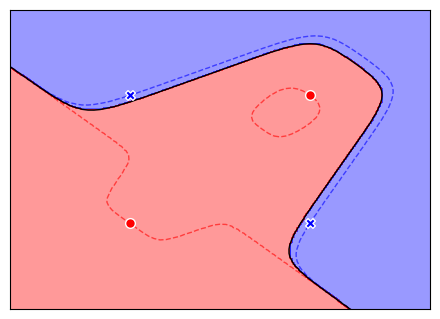

In [47]:
# 多项式核的使用
X = np.array([[-1,-1], [-1,2], [2,2], [2,-1]])
y = np.array([1, -1, 1, -1, ])
svm_ = SVM_with_kernel_function(X, y, "polynomial", zeta=1, gamma=6, d=11)

fig, ax = plt.subplots(figsize=(6, 3))
fig.subplots_adjust(left=0.15, right=0.85, top=0.999, bottom=0.001)
xy_min, xy_max = -3, 4
ax.set(xticks=[], yticks=[])
ax.set_xlim(xy_min, xy_max),ax.set_ylim(xy_min, xy_max)
markers = ('X', 'o')
colors = ('blue', 'red')
for cl, m, color in zip(np.unique(y), markers, colors):
	ax.scatter(X[y==cl, 0], X[y==cl, 1], alpha=1, c=color, edgecolors='w', marker = m, zorder=9, s=7**2)
cm = ListedColormap(('blue', 'red'))
resolution = 0.03
xx1, xx2 = np.meshgrid(np.arange(xy_min, xy_max, resolution), np.arange(xy_min, xy_max, resolution))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))
yy = svm_(xx)
yy = np.where(yy<0, -1, 1).reshape(xx1.shape)
ax.contourf(xx1, xx2, yy, alpha=0.4, cmap=cm)
xx1, xx2 = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))
yy = svm_(xx).reshape(xx1.shape)
ax.contour(xx1, xx2, yy, [-1, 1], colors=('b', 'r'), antialiased=True, linestyles='dashed', linewidths=1, alpha=0.6)
ax.contour(xx1, xx2, yy, [0], antialiased=True, colors='k', linewidths=1)
plt.show()

也可以使用sklearn封装好的SVM

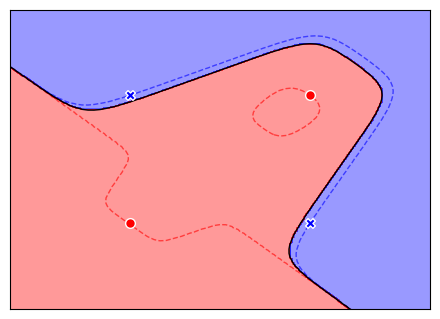

In [48]:
def svm_with_kernel_function_in_sklearn(X: np.ndarray, y: np.ndarray, kernel: str = "linear", **kwargs):
    params = {"return_svm": True}
    if kernel == "linear":
        params.update({"kernel": "linear"})
    elif kernel == "polynomial":
        params.update({"kernel": "poly", 
                       "degree": kwargs.pop("d"), 
                       "gamma": kwargs.pop("gamma"),
                       "coef0": kwargs.pop("zeta")})
    elif kernel == "gaussian":
        params.update({"kernel": "rbf",
                       "gamma": kwargs.pop("gamma")})
    clf = SVM_in_sklearn(X, y, **params)
    return SVMWithKernel(None, None, None, kernel, None, clf)

svm_ = svm_with_kernel_function_in_sklearn(X, y, "polynomial", zeta=1, gamma=6, d=11)

fig, ax = plt.subplots(figsize=(6, 3))
fig.subplots_adjust(left=0.15, right=0.85, top=0.999, bottom=0.001)
xy_min, xy_max = -3, 4
ax.set(xticks=[], yticks=[])
ax.set_xlim(xy_min, xy_max),ax.set_ylim(xy_min, xy_max)
markers = ('X', 'o')
colors = ('blue', 'red')
for cl, m, color in zip(np.unique(y), markers, colors):
	ax.scatter(X[y==cl, 0], X[y==cl, 1], alpha=1, c=color, edgecolors='w', marker = m, zorder=9, s=7**2)
cm = ListedColormap(('blue', 'red'))
resolution = 0.03
xx1, xx2 = np.meshgrid(np.arange(xy_min, xy_max, resolution), np.arange(xy_min, xy_max, resolution))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))
yy = svm_(xx)
yy = np.where(yy<0, -1, 1).reshape(xx1.shape)
ax.contourf(xx1, xx2, yy, alpha=0.4, cmap=cm)
xx1, xx2 = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))
yy = svm_(xx).reshape(xx1.shape)
ax.contour(xx1, xx2, yy, [-1, 1], colors=('b', 'r'), antialiased=True, linestyles='dashed', linewidths=1, alpha=0.6)
ax.contour(xx1, xx2, yy, [0], antialiased=True, colors='k', linewidths=1)
plt.show()

高斯核可以将特征映射到无限维的空间中，对于转换的维度越高，数据集变得线性可分的概率就会越大，另外相比较多项式核，高斯核只有一个超参数$\gamma$，因此相对来说在工程上更容易调节参数。

而无限维的特征空间，意味着决策边界是非常复杂的多项式，在[线性回归](./linear_regression.ipynb)中我们讨论过多项式的$d_{vc}$为

$$d_{vc}\le{m+M\choose m}={m+M\choose M}$$

根据工程经验需要$10d_{vc}$大小的数据集才能保证学习是可行的，也就是结果是PAC的，高斯核对应的决策边界是无限复杂的多项式，那么就表明学习是不可行的吗，其实不然，可以通过超参数$\gamma$来调节模型的复杂度，下面我们来看一个例子

随机生成100个大小的数据集$D$，并且使用不同$\gamma$来调节模型的复杂度，可以看到$\gamma$超过10以后，模型开始出现过拟合，将部分点单独分开了。

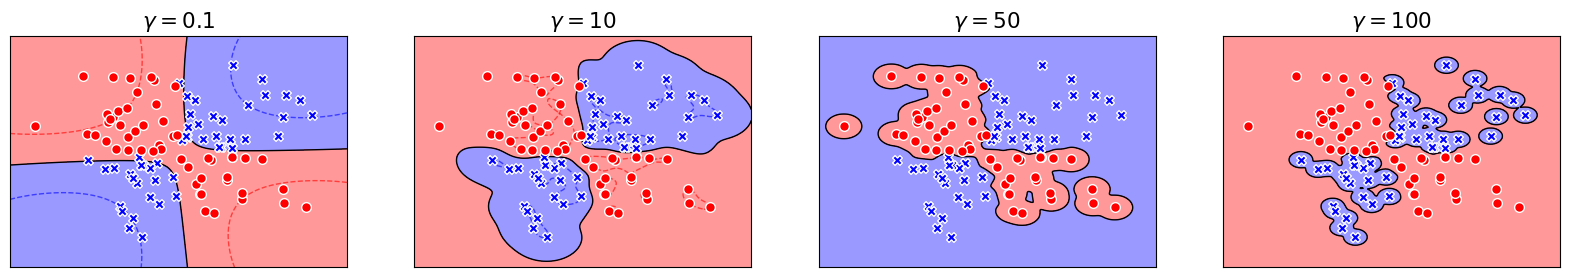

In [78]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
np.random.seed(0)
X = np.random.randn(100, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

def use_gaussian(gamma, ax):
    svm_ = svm_with_kernel_function_in_sklearn(X, y, "gaussian", gamma=gamma)
    Z = svm_(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, 0, alpha=0.4, cmap=cm)
    ax.contour(xx, yy, Z, [-1, 1], colors=('b', 'r'), antialiased=True, linestyles='dashed', linewidths=1, alpha=0.6)
    ax.contour(xx, yy, Z, [0], antialiased=True, colors='k', linewidths=1)

fig, axes = plt.subplots(figsize=(20, 3), ncols=4, nrows=1)
gammas = (0.1, 10, 50, 100)
cm = ListedColormap(("blue", "red"))

for ax, gamma in zip(axes, gammas):
    ax.set(xticks=[], yticks=[])
    ax.set_title(f"$\gamma={gamma}$")
    use_gaussian(gamma, ax)
    for cl, m, color in zip(np.unique(y), markers, colors):
        ax.scatter(X[y==cl, 0], X[y==cl, 1], alpha=1, c=color, 
                   edgecolors='w', marker = m, zorder=9, s=7**2)

## 软间隔支持向量机
前面介绍硬间隔支持向量机只能够处理线性可分的数据集$D$，不仅要求能够正确分类，还要求决策边界的宽度内不能包含点。

对于线性不可分的数据集，只能通过升维将数据集映射成高维下线性可分的数据再运用硬间隔支持向量机来学习，高维随之而来会带来模型复杂度的提升，容易发生过拟合问题。如果允许部分点犯错，也就是允许部分点分错或者出现在决策边界宽度内，那么可以避免模型复杂度提升带来的过拟合问题，因此引入软间隔支持向量机(soft margin support vector machine)。

硬间隔支持向量机要求
$$y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}+b) \ge 1$$

而软间隔支持向量机没有这个要求，软间隔关心的是决策边界的宽度和犯错点的个数，联合起来就是

$$\frac{1}{2}\|\boldsymbol{w}\|^2+C\cdot \sum_{i}I\Big(y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}+b) < 1\Big),\quad C\in\mathbb{R}$$

其中$C$是超参数，表示关心决策边界宽度更大还是犯错点的数量更多，如果$C$较小，表示我们更在乎决策边界的宽度，反之则是犯错点的数量。

由于包含指示函数$I$，不能够直接求导，因此需要进一步变形。

对于两个平行的超平面

$$\begin{aligned}
    \boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b &= 0\\
    \boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b &= \xi
\end{aligned}$$

其距离为

$$d=\frac{\xi}{||\boldsymbol{w}||}$$

其次对于数据集$D$中的任意点$(\boldsymbol{x_i}, y_i)$，都能够找到包含该点并且和决策边界平行的超平面，记为

$$\boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b=y_i(1-\xi_i)$$

其与超平面$\boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b=y_i$的距离为

$$d_i=\frac{\xi_i}{\boldsymbol{w}}$$


![](../resources/support_vector_machines4.png)


那么软间隔的示性函数部分可以转化为距离

$$\begin{cases}
    d_i = 0, &y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}+b) \ge 1 \\
    d_i = \frac{\xi_i}{||\boldsymbol{w}||}, &y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}+b) \lt 1
\end{cases}$$

- 对于犯错的点，总能找到合适的$\xi_i$，使得$y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b)=1-\xi_i$
- 对于没有犯错的点，$x_i=0$，因此有$y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x}+b)\ge 1=1-\xi_i$
- $d_i$是和$\xi_i$成正比的

综上，可以把软间隔的条件极值改为

$$\begin{aligned}
    \min_{\boldsymbol{w},b,\xi_i}\quad
        &\frac{1}{2}\|\boldsymbol{w}\|^2+C\cdot \sum_{i}\xi_i,\quad C\in\mathbb{R}\\
    s.t.\quad
        &y_i(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_i}+b)\ge 1-\xi_i,\quad\xi_i\ge 0
\end{aligned}$$

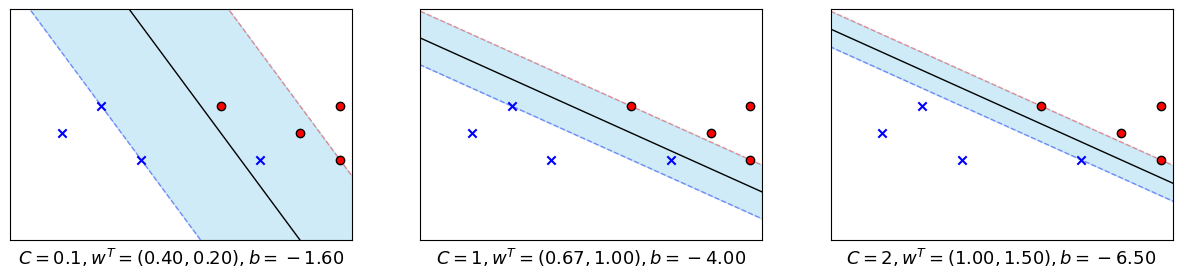

In [88]:
X = np.array([[3, 3],[5, 2],[6,3],[6,1],[1, 1],[4,1],[-1,2],[0,3]])
y = np.array([1,1,1,1,-1,-1,-1,-1])

def soft_margin_SVM(C: float, ax: plt.Axes):
	m = X.shape[0]	
	n = X.shape[1]	
	w = cp.Variable((n,1))
	b = cp.Variable() 
	xi = cp.Variable((m,1)) 
	objective = cp.Minimize(0.5*cp.norm(w)**2+C*cp.sum(xi))
	constraints = [cp.multiply(y.reshape(-1,1), X@w + b) >= 1 - xi, xi >= 0 ]
	prob = cp.Problem(objective, constraints) 
	prob.solve(solver=cp.ECOS) 
	x1_min, x1_max = -2, 6
	x2_min, x2_max = -1.7, 6.3

	ax.set_xticks(()),ax.set_yticks(())
	ax.set_xlim(x1_min-0.3, x1_max+0.3),ax.set_ylim(x2_min-0.3, x2_max+0.3)
	ax.set_xlabel(r'$C={}, w^T=({:.2f},{:.2f}), b={:.2f}$'.format(C, w.value[0][0], w.value[1][0], b.value))

	markers = ('x', 'o')
	colors = ('blue', 'red')
	for cl, m, color in zip(np.unique(y), markers, colors):
		edgecolors = 'k'
		if m == 'x':
			edgecolors = None
		ax.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=1, 
			 c=color, edgecolors=edgecolors, marker = m, zorder=9)

	xx = np.arange(x1_min-1, x1_max+1, 0.1)
	yy = - w.value[0]/w.value[1] * xx  - b.value / w.value[1]
	ax.plot(xx1, yy+1/w.value[1], 'r--', lw=1, alpha=0.4)	
	ax.plot(xx1, yy, 'k', lw=1)								
	ax.plot(xx1, yy-1/w.value[1], 'b--', lw=1, alpha=0.4)	
	ax.fill_between(xx1, yy-1/w.value[1], yy+1/w.value[1], color='skyblue', alpha=0.4)

fig, axes = plt.subplots(figsize=(15, 3), ncols=3, nrows=1)
Cs = (0.1, 1, 2)

for ax, C in zip(axes, Cs):
	soft_margin_SVM(C, ax)

plt.show()

### 软间隔支持向量机的对偶算法
对于下面的条件极值

$$\begin{aligned}
    \min_{\boldsymbol{\lambda}}\quad
        &\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_i\lambda_jy_iy_j\boldsymbol{x}_i^{\text{T}}\boldsymbol{x}_j-\sum_{i=1}^{n}\lambda_i\\
    s.t.\quad
        &0\leq\lambda_i\leq C,\quad\sum_{i=1}^{n}\lambda_i y_i=0\\
\end{aligned}$$

如果$\lambda_i \ne 0$，说明$\boldsymbol{x_i}$为支持向量，所有支持向量的集合$K=\{(\boldsymbol{x_k}, y_k)\}$

$$\hat{\boldsymbol{w}}=\sum_{k}\lambda_ky_k\boldsymbol{x}_k$$

如果存在$0 \le \lambda_j \le C$，并且其对应的特征为$\boldsymbol{x_j}$，那么

$$\hat{b}=y_j-\sum_{k}\lambda_ky_k\boldsymbol{x}_k^{\mathrm{T}}\boldsymbol{x}_j$$